In [1]:
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
  .appName('Yelp! Business Analysis')\
  .getOrCreate()

In [3]:
# Directory where the raw data is stored
data_folder = "gs://ca4022_yelp_data/data_raw/"

df_bus = spark.read.csv(data_folder + "business.csv", header=True, sep= ",", inferSchema=True)

In [4]:
df_bus.head()

Row(business_id='f9NumwFMBDn751xgFiRbNA', name='The Range At Lake Norman', address='10913 Bailey Rd', city='Cornelius', state='NC', postal_code='28031', latitude='35.4627242', longitude='-80.8526119', stars='3.5', review_count=36.0, is_open=1.0, categories='Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping')

In [5]:
#way of easily displaying first 5 rows
df_bus1 = df_bus.toPandas()
df_bus.limit(5).toPandas()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.4627242,-80.8526119,3.5,36.0,1.0,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.5694041,-111.8902637,5.0,4.0,1.0,"Health & Medical, Fitness & Instruction, Yoga,..."
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.58007,5.0,5.0,1.0,"Pets, Pet Services, Pet Groomers"
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.2197281,-115.1277255,2.5,3.0,0.0,"Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.4280652,-111.7266485,4.5,26.0,1.0,"Home Services, Plumbing, Electricians, Handyma..."


In [6]:
#are all business Id's unique?
print("Number of Distinct Business IDs", df_bus.select("business_id").distinct().count())
print("Number of Business IDs", df_bus.select("business_id").count())

Number of Distinct Business IDs 209393
Number of Business IDs 209393


As we can see there is no need to clean the dataset as all businesses are unique

### Cities and States with the most businesses

In [7]:
from pyspark.sql.types import IntegerType
#df_bus.groupBy('city').count().orderBy('count'.desc()).show()
df_bus.groupBy('city').count().sort(col("count").desc()).show(truncate=False)

+---------------+-----+
|city           |count|
+---------------+-----+
|Las Vegas      |31631|
|Toronto        |20366|
|Phoenix        |20170|
|Charlotte      |10422|
|Scottsdale     |9342 |
|Calgary        |8377 |
|Pittsburgh     |7630 |
|Montréal       |6979 |
|Mesa           |6577 |
|Henderson      |5272 |
|Tempe          |4797 |
|Chandler       |4580 |
|Cleveland      |3857 |
|Glendale       |3824 |
|Gilbert        |3745 |
|Madison        |3685 |
|Mississauga    |3518 |
|Peoria         |2080 |
|Markham        |1963 |
|North Las Vegas|1677 |
+---------------+-----+
only showing top 20 rows



In [8]:
df_bus.groupBy('state').count().sort(col("count").desc()).show(truncate=False)

+-----+-----+
|state|count|
+-----+-----+
|AZ   |60802|
|NV   |39084|
|ON   |36626|
|OH   |16392|
|NC   |16218|
|PA   |12376|
|QC   |10233|
|AB   |8682 |
|WI   |5525 |
|IL   |2034 |
|SC   |1328 |
|CA   |23   |
|NY   |22   |
|TX   |6    |
|WA   |5    |
|AL   |3    |
|GA   |3    |
|FL   |3    |
|MI   |2    |
|NE   |2    |
+-----+-----+
only showing top 20 rows



### List of the Most Reviewed Businesses

In [24]:
from pyspark.sql.functions import col

df_bus_clean[['name', 'review_count', 'city', 'stars']].sort(col("review_count").desc()).show(truncate=False)

+--------------------------------+------------+---------+-----+
|name                            |review_count|city     |stars|
+--------------------------------+------------+---------+-----+
|Bacchanal Buffet                |10129.0     |Las Vegas|4.0  |
|Mon Ami Gabi                    |9264.0      |Las Vegas|4.0  |
|Wicked Spoon                    |7383.0      |Las Vegas|3.5  |
|Hash House A Go Go              |6751.0      |Las Vegas|4.0  |
|Gordon Ramsay BurGR             |5494.0      |Las Vegas|4.0  |
|Earl of Sandwich                |5232.0      |Las Vegas|4.5  |
|Yardbird Southern Table & Bar   |4828.0      |Las Vegas|4.5  |
|The Buffet At Wynn              |4803.0      |Las Vegas|3.5  |
|Secret Pizza                    |4803.0      |Las Vegas|4.0  |
|The Cosmopolitan of Las Vegas   |4740.0      |Las Vegas|4.0  |
|Gordon Ramsay Hell's Kitchen    |4672.0      |Las Vegas|4.5  |
|Luxor Hotel and Casino Las Vegas|4670.0      |Las Vegas|2.5  |
|The Buffet at Bellagio          |4628.0

19 of the top 20 most reviewed businesses reside in Las Vegas. Las Vegas is the City with the most businesses in this dataset so this makes sense.

### Which Cities Have the Most Businesses?

Text(0.5, 1.0, 'Top 20 Cities with Highest Number of Businesses')

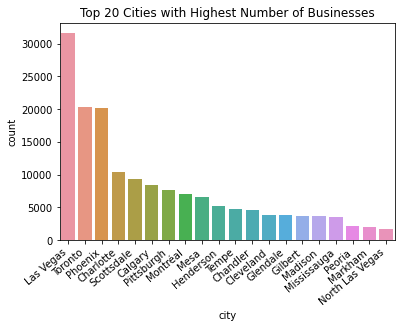

In [25]:
import seaborn as sns

ax = sns.barplot(x = 'city', y= 'count', data = df_bus_clean.groupBy('city').count().sort(col("count").desc()).limit(20).toPandas())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Top 20 Cities with Highest Number of Businesses')

### Which Cities have the Most Business Reviews?

Text(0.5, 1.0, 'Top 20 Cities with Highest Number of Business Reviews')

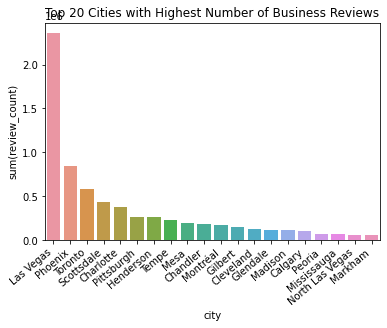

In [28]:
ax = sns.barplot(x = 'city', y= 'sum(review_count)', data = df_bus_clean.groupBy('city').sum('review_count').sort(col("sum(review_count)").desc()).limit(20).toPandas())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Top 20 Cities with Highest Number of Business Reviews')

### Average Stars
Now we will look at the cities ranked by the average stars of their businesses \
Let's set a minimum number of reviews for a city to be feature first. We will only be looking for average stars of cities with greater than 50,000 reviews.

In [14]:
bus_pan = df_bus_clean.toPandas()
city_business_reviews = bus_pan[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)


Text(0.5, 1.0, 'Cities with greater than 50k reviews ranked by average stars')

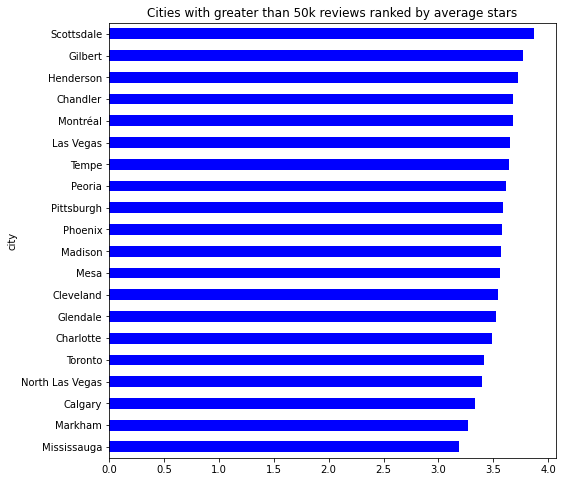

In [29]:
city_business_reviews[city_business_reviews.review_count > 50000]['stars'].sort_values()\
.plot(kind='barh', stacked=False, figsize=[8,8], colormap='winter')
plt.title('Cities with greater than 50k reviews ranked by average stars')

In [16]:
df_bus.groupBy('city').sum('review_count').sort(col("sum(review_count)").desc()).limit(20).show(truncate=False)

+---------------+-----------------+
|city           |sum(review_count)|
+---------------+-----------------+
|Las Vegas      |2360735.0        |
|Phoenix        |842317.0         |
|Toronto        |583512.0         |
|Scottsdale     |439439.0         |
|Charlotte      |371580.0         |
|Pittsburgh     |262412.0         |
|Henderson      |261244.0         |
|Tempe          |229594.0         |
|Mesa           |197214.0         |
|Chandler       |183475.0         |
|Montréal       |171059.0         |
|Gilbert        |153826.0         |
|Cleveland      |129489.0         |
|Glendale       |118096.0         |
|Madison        |114475.0         |
|Calgary        |107106.0         |
| PC            |85032.0          |
|Peoria         |69539.0          |
|Mississauga    |65557.0          |
|North Las Vegas|60405.0          |
+---------------+-----------------+



In [17]:
df_bus = df_bus.withColumn("stars", df_bus["stars"].cast("double"))
df_bus.groupBy('city').mean('stars').sort(col("avg(stars)").desc()).limit(20).show(truncate=False)
#.sum('review_count').sort(col("sum(review_count)").desc()).limit(20).show(truncate=False)
#df_bus.groupBy('city').sum('review_count').sort(col("sum(review_count)").desc()).limit(20).show(truncate=False)
#df_bus[df_bus.review_count > 50000]

+----------------+----------+
|city            |avg(stars)|
+----------------+----------+
|Nevada          |5.0       |
|Garrettsville   |5.0       |
|QUEEN CREEK     |5.0       |
|Alburg          |5.0       |
|Huntington Beach|5.0       |
|Bentleyville    |5.0       |
|Lakewood, Oh    |5.0       |
|East Mesa       |5.0       |
|​Gilbert        |5.0       |
|Auburn          |5.0       |
|HENDERSON       |5.0       |
|Sainte-Marthe   |5.0       |
|Ahwahtukee      |5.0       |
|SCOTTSDALE      |5.0       |
|Palgrave        |5.0       |
|Litchfield park |5.0       |
|Chateau         |5.0       |
|Sun CIty        |5.0       |
|Fort MILL       |5.0       |
|City Center     |5.0       |
+----------------+----------+



In [18]:
df_bus.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: double (nullable = true)
 |-- is_open: double (nullable = true)
 |-- categories: string (nullable = true)



### Distribution of Stars
Let's take a look at the distribution of the stars for businesses. Will there be more businesses with high, middling or low ratings? 

In [20]:
data_clean_folder = "gs://ca4022_yelp_data/data_clean/"

df_bus_clean = spark.read.csv(data_clean_folder + "business.csv", header=True, sep= ",", inferSchema=True)

Text(0.5, 0.98, 'Business Stars Distribution')

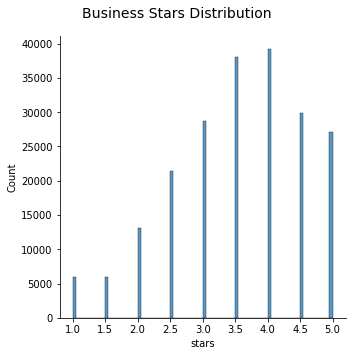

In [21]:
import seaborn as sns
ax = sns.displot(df_bus_clean.toPandas(),  x = 'stars')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#ax.set_title('Distribution of stars')
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Business Stars Distribution', fontsize=14)

As we can see there is a relatively left-skewed distribution of stars for businesses, with 4.0 being the most common rating. This could lead to the observation that people are more likely to give a rating when they've had a good experience.